# Nucleic Acid Folding Project

## Introduction

This project addresses the Nucleic Acid Folding Problem, which involves predicting the secondary structure of a nucleic acid molecule from its nucleotide sequence. Several integer linear programming (ILP) models were developed to determine the optimal pairing of nucleotides arranged in a circular string, as shown in Figure 1. For this project, we let S denote a string of n characters made up of the Nucleic Acid alphabet {A, C, U, G}. For example, S = ACGUGCCACGAU.


In [1]:
from IPython.display import Image, IFrame
Image('Figure1.png', width = 700)

The secondary structure that we try to predict is the pairing of nucleotides in the circle. Every nucleotide can be in at most one pair. An example of a pairing can be seen in Figure 2.

In [2]:
Image('Figure2.png', width = 500)

The models range from basic assumptions—allowing only complementary nucleotide pairings and maximizing matched pairs—to more complex biological considerations, such as permitting certain non-complementary pairs, evaluating the stability of stacked quartets, and allowing crossing pairs. The final model formulations were tested on various nucleotide sequences, analyzing scalability, constraints, and performance to find the most efficient approach. The entire modeling process and analysis are detailed below.


> *Note: for the coding solutions, we will use S = ACGUGCCACGAU*


## Modeling Process and Analysis

### Import Packages and Write Problem Data

In [3]:
from gurobipy import GRB,Model

In [4]:
# Write the nucleotide sequence string
S = "ACGUGCCACGAU"
n = len(S)


# Data
a_ij = {f'a({i},{j})': 1 if (S[i] == 'A' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'A') else 0
            for i in range(n) for j in range(i + 1, n)}
b_ij = {f'b({i},{j})': 1 if (S[i] == 'G' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'G') else 0
            for i in range(n) for j in range(i + 1, n)}
c_ij = {f'c({i},{j})': 1 if (S[i] == 'A' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'A') else 0
            for i in range(n) for j in range(i + 1, n)}
d_ij = {f'd({i},{j})': 1 if (S[i] == 'G' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'G') else 0
            for i in range(n) for j in range(i + 1, n)}
r_ij = {f'r({i},{j})': min(j-i, n-j+i) for i in range(n) for j in range(i + 1, n)}
weights = {'GC': 3,'AU': 2,'GU': 0.1,'AC': 0.05}

## Model 1

A nested pairing, or non-crossing pairing, is a pairing for which each pair is connected by a line inside the
circle and none of the lines cross. See Figure 3.


In [5]:
Image('Figure3.png', width = 850)

In the simplest model we consider, we assume:
* Only nested pairings are allowed
* Only complementary nucleotides (A, U ) and (G, C) can be in a pair
* The most stable pairing is the most likely
* The most stable pairing is the one with most matched pairs

Formulate an integer linear program to find the most likely pairing under these assumptions

### Code

In [6]:
m1 = Model('Project_Model1')
m1.setParam('OutputFlag',True)


# Add variables
x_ij = {(i, j): m1.addVar(vtype=GRB.BINARY, name=f'x({i},{j})') for i in range(n) for j in range(i+1, n)}


# Add constraints

# Complementarity
for i in range(n):
    for j in range(i+1, n):
        m1.addConstr(x_ij[i, j] <= a_ij[f'a({i},{j})'] + b_ij[f'b({i},{j})'], name = f'compl({i},{j})')

# Non-crossing
for i in range(n):
    for j in range(i + 1, n):
        for k in range(n):
            for l in range(k + 1, n):
                if i < k < j < l or k < i < l < j:
                    if (i, j) in x_ij and (k, l) in x_ij:
                        m1.addConstr(x_ij[i, j] + x_ij[k, l] <= 1, name = f'non_cross({i},{j},{k},{l})')

# Each nucleotide in at most 1 pair
for k in range(n):
    m1.addConstr(sum(x_ij[i, k] for i in range(k) if (i, k) in x_ij) +
                sum(x_ij[k, j] for j in range(k + 1, n) if (k, j) in x_ij) <= 1, name = f'single_pair{k}')


# Set the objective
m1.setObjective(sum(x_ij[i, j] for i in range(n) for j in range(i+1, n)), GRB.MAXIMIZE)


# Optimize the model
m1.optimize()


# Print the result
status_code = {1:'loaded', 2:'optimal', 3:'infeasible',\
               4:'inf_or_unbd', 5:'unbounded'}
status = m1.status

print('\nThe solution found is {}.'.format(status_code[status]))
if status == 2:
    # Retrieve variables value
    print('The optimal objective value is {}'.format(m1.objVal))
    print('Number of AU pairs is {}'.format(sum(a_ij[f'a({i},{j})'] * m1.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GC pairs is {}'.format(sum(b_ij[f'b({i},{j})'] * m1.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    # for v in m1.getVars():
    #     print('%s = %g' % (v.varName, v.x))
else:
    print('The solution found is not optimal.')

Set parameter Username


Academic license - for non-commercial use only - expires 2025-01-13


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 20.6.0 20G527)


CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Optimize a model with 1068 rows, 66 columns and 2178 nonzeros


Model fingerprint: 0xad95f1da


Variable types: 0 continuous, 66 integer (66 binary)


Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+00]


Found heuristic solution: objective 5.0000000


Presolve removed 1064 rows and 62 columns


Presolve time: 0.00s


Presolved: 4 rows, 4 columns, 8 nonzeros


Found heuristic solution: objective 5.0000000


Variable types: 0 continuous, 4 integer (4 binary)


Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


Solution count 2: 5 5 


Optimal solution found (tolerance 1.00e-04)


Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%



The solution found is optimal.
The optimal objective value is 5.0
Number of AU pairs is 2.0
Number of GC pairs is 3.0


### Solution

In Model 1 we obtained an optimal objective value of 5. This means that the most likely pairing consists of 5 pairs. Furthermore, the most stable pairing of this nucleotide sequence has 2 AU pairs and 3 GC pairs.

## Model 2

In our next model, we assume:
* Only nested pairings are allowed
* Any pair of nucleotides must be at least distance 3 away from each other
* Complementary matched pairs (A, U ) and (G, C) are allowed
* Some non-complementary matched pairs, (G, U ) and (A, C) are allowed
* The most stable pairing is the most likely
* The stability of a pairing is a weighted function of the number of each type of pairs

The weight of different pairs can be seen in Table 1.


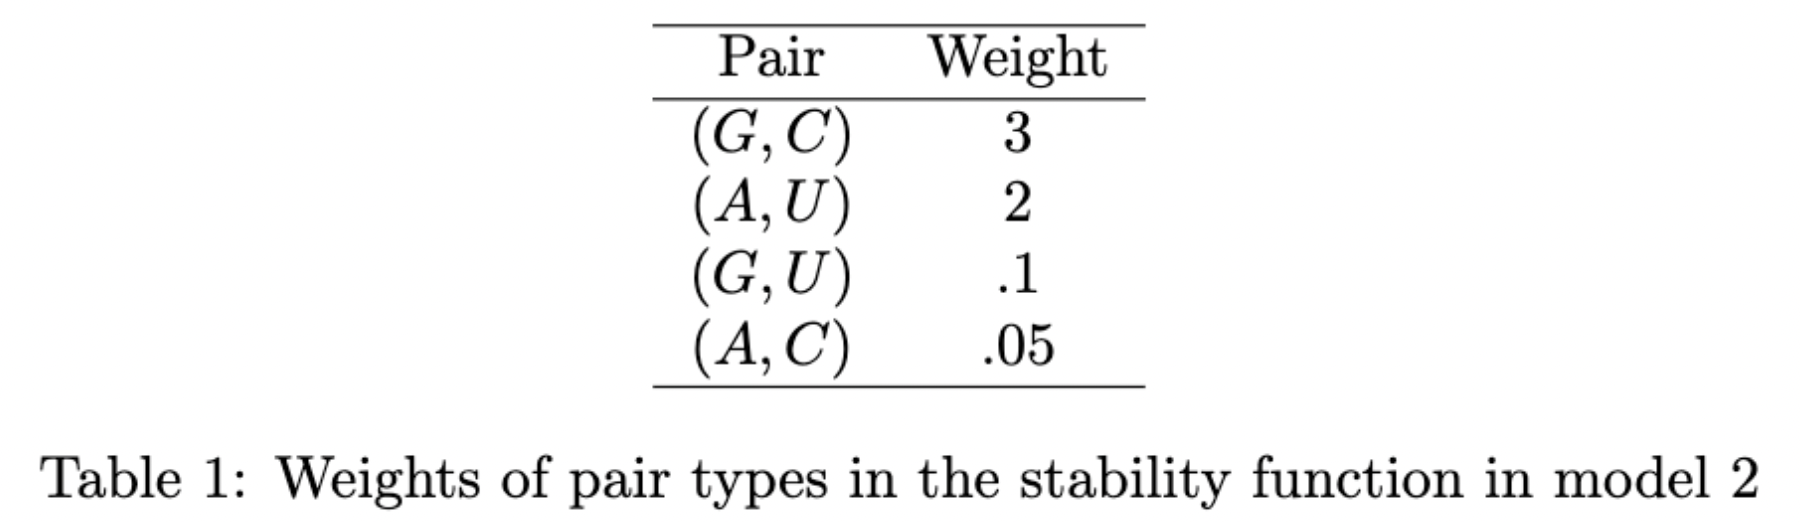

In [7]:
Image('Table1.png', width = 500)

Formulate an integer linear program to find the most likely pairing under these assumptions.


### Code

In [8]:
m2 = Model('Project_Model2')
m2.setParam('OutputFlag',True)


# Add variables
x_ij = {(i, j): m2.addVar(vtype=GRB.BINARY, name=f'x({i},{j})') for i in range(n) for j in range(i+1, n)}


# Add constraints

# Complementarity
for i in range(n):
    for j in range(i+1, n):
        m2.addConstr(x_ij[i, j] <= a_ij[f'a({i},{j})'] + b_ij[f'b({i},{j})'] + c_ij[f'c({i},{j})'] + d_ij[f'd({i},{j})'], name = f'compl({i},{j})')

# Non-crossing
for i in range(n):
    for j in range(i + 1, n):
        for k in range(n):
            for l in range(k + 1, n):
                if i < k < j < l or k < i < l < j:
                    if (i, j) in x_ij and (k, l) in x_ij:
                        m2.addConstr(x_ij[i, j] + x_ij[k, l] <= 1, name = f'non_cross({i},{j},{k},{l})')

# Each nucleotide in at most 1 pair
for k in range(n):
    m2.addConstr(sum(x_ij[i, k] for i in range(k) if (i, k) in x_ij) +
                sum(x_ij[k, j] for j in range(k + 1, n) if (k, j) in x_ij) <= 1, name = f'single_pair{k}')

# Distance
for i in range(n):
    for j in range(i+1, n):
        m2.addConstr(3*x_ij[i, j] <= r_ij[f'r({i},{j})'], name = f'dist({i},{j})')


# Set the objective
stability = sum(weights['GC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'G')) \
          + sum(weights['AU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'A')) \
          + sum(weights['GU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'G')) \
          + sum(weights['AC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'A'))
m2.setObjective(stability, GRB.MAXIMIZE)


# Optimize the model
m2.optimize()


# Print the result
status_code = {1:'loaded', 2:'optimal', 3:'infeasible',\
               4:'inf_or_unbd', 5:'unbounded'}
status = m2.status

print('\nThe solution found is {}.'.format(status_code[status]))
if status == 2:
    # Retrieve variables value
    print('The optimal objective value is {}'.format(m2.objVal))
    print('Number of AU pairs is {}'.format(sum(a_ij[f'a({i},{j})'] * m2.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GC pairs is {}'.format(sum(b_ij[f'b({i},{j})'] * m2.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of AC pairs is {}'.format(sum(c_ij[f'c({i},{j})'] * m2.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GU pairs is {}'.format(sum(d_ij[f'd({i},{j})'] * m2.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    # for v in m2.getVars():
    #     print('%s = %g' % (v.varName, v.x))
else:
    print('The solution found is not optimal.')

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 20.6.0 20G527)


CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Optimize a model with 1134 rows, 66 columns and 2244 nonzeros


Model fingerprint: 0x05265877


Variable types: 0 continuous, 66 integer (66 binary)


Coefficient statistics:


  Matrix range     [1e+00, 3e+00]


  Objective range  [5e-02, 3e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 6e+00]


Found heuristic solution: objective 5.0000000


Presolve removed 1113 rows and 49 columns


Presolve time: 0.00s


Presolved: 21 rows, 17 columns, 114 nonzeros


Variable types: 0 continuous, 17 integer (17 binary)


Found heuristic solution: objective 6.0000000


Root relaxation: objective 8.000000e+00, 9 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


*    0     0               0       8.0000000    8.00000  0.00%     -    0s


Explored 1 nodes (9 simplex iterations) in 0.01 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


Solution count 3: 8 6 5 


Optimal solution found (tolerance 1.00e-04)


Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%



The solution found is optimal.
The optimal objective value is 8.0
Number of AU pairs is 1.0
Number of GC pairs is 2.0
Number of AC pairs is 0.0
Number of GU pairs is 0.0


### Solution

In Model 2 we obtained an optimal objective value of 8. This means that the stability of the pairing is equal to 8. Furthermore, the most stable/likely pairing of this nucleotide sequence, under the assumptions of Model 2, is made of 1 AU pair and 2 GC pairs.

## Model 3

A stacked quartet consists of two matched pairs (i, j) and (i + 1, j − 1). Figure 4 shows two stacked quartets: {(9, 1), (10, 0)} and {(8, 2), (9, 1)}.

In [9]:
Image('Figure4.png', width = 500)

Note the stacked quartet {(1, 0), (2, 11)} could be seen as having i = 1 and j = 0 (thus i + 1 = 2 and j − 1 mod 12 = 11) or i = 11 and j = 2 (thus i + 1 mod 12 = 0 and j − 1 = 1). Make sure not to double count a stacked quartet.

In our next model, we assume
* Any pair of nucleotides must be at least distance 3 away from each other
* Complementary matched pairs (A, U ) and (G, C) are allowed
* Some non-complementary matched pairs, (G, U ) and (A, C) are allowed
* The most stable pairing is the most likely
* The stability of a pairing is a weighted function of the number of each type of pairs and the number of stacked quartets

The weights of different pairs and the stacked quartets can be seen in Table 2.


In [10]:
Image('Table2.png', width = 400)

Formulate an integer linear program to find the most likely pairing under these assumptions.

### Code

In [11]:
m3 = Model('Project_Model3')
m3.setParam('OutputFlag',True)


# Add variables
x_ij = {(i, j): m3.addVar(vtype=GRB.BINARY, name=f'x({i},{j})') for i in range(n) for j in range(i+1, n)}
s_ijkl = {(i, j, k, l): m3.addVar(vtype=GRB.BINARY, name=f's({i},{j},{k},{l})') for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l}
t_ijkl = {(i, j, k, l): m3.addVar(vtype=GRB.BINARY, name=f't({i},{j},{k},{l})') for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (j+1)%n and l== (i-1)%n and i!= k and j!= l}


# Add constraints

# Complementarity
for i in range(n):
    for j in range(i+1, n):
        m3.addConstr(x_ij[i, j] <= a_ij[f'a({i},{j})'] + b_ij[f'b({i},{j})'] + c_ij[f'c({i},{j})'] + d_ij[f'd({i},{j})'], name = f'compl({i},{j})')

# Non-crossing
for i in range(n):
    for j in range(i + 1, n):
        for k in range(n):
            for l in range(k + 1, n):
                if i < k < j < l or k < i < l < j:
                    if (i, j) in x_ij and (k, l) in x_ij:
                        m3.addConstr(x_ij[i, j] + x_ij[k, l] <= 1, name = f'non_cross({i},{j},{k},{l})')

# Each nucleotide in at most 1 pair
for k in range(n):
    m3.addConstr(sum(x_ij[i, k] for i in range(k) if (i, k) in x_ij) +
                sum(x_ij[k, j] for j in range(k + 1, n) if (k, j) in x_ij) <= 1, name = f'single_pair{k}')

# Distance
for i in range(n):
    for j in range(i+1, n):
        m3.addConstr(3*x_ij[i, j] <= r_ij[f'r({i},{j})'], name = f'dist({i},{j})')

# Stacked Quartets
for i in range(n):
    for j in range(i+1, n):
        for k in range(n):
            for l in range(k+1, n):

                if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l:
                    m3.addConstr(2*s_ijkl[i, j, k, l] <= x_ij[i, j] + x_ij[k, l], name = f'stacked({i},{j})')

                elif k == (j+1)%n and l== (i-1)%n and i!= k and j!= l:
                    m3.addConstr(2*t_ijkl[i, j, k, l] <= x_ij[i, j] + x_ij[k, l], name = f'stacked({i},{j})')
                    m3.addConstr(t_ijkl[i, j, k, l] == t_ijkl[k, l, i, j], name = f'stacked({i},{j})')


# Set the objective
stability = sum(weights['GC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'G')) \
          + sum(weights['AU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'A')) \
          + sum(weights['GU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'G')) \
          + sum(weights['AC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'A'))\
          + sum(s_ijkl[i,j,k,l] for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l)\
          + 0.5*sum(t_ijkl[i,j,k,l] for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (j+1)%n and l== (i-1)%n and i!= k and j!= l)
m3.setObjective(stability, GRB.MAXIMIZE)


# Optimize the model
m3.optimize()


# Print the result
status_code = {1:'loaded', 2:'optimal', 3:'infeasible',\
               4:'inf_or_unbd', 5:'unbounded'}
status = m3.status

print('\nThe solution found is {}.'.format(status_code[status]))
if status == 2:
    # Retrieve variables value
    print('The optimal objective value is {}'.format(m3.objVal))
    print('Number of AU pairs is {}'.format(sum(a_ij[f'a({i},{j})'] * m3.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GC pairs is {}'.format(sum(b_ij[f'b({i},{j})'] * m3.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of AC pairs is {}'.format(sum(c_ij[f'c({i},{j})'] * m3.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GU pairs is {}'.format(sum(d_ij[f'd({i},{j})'] * m3.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of stacked quartets is {}'.format(sum(s_ijkl[i, j, k, l].X for (i, j, k, l) in s_ijkl if s_ijkl[i, j, k, l].X > 0.5)\
     + 0.5 * sum(t_ijkl[i, j, k, l].X for (i, j, k, l) in t_ijkl if t_ijkl[i, j, k, l].X > 0.5)))
    # for v in m3.getVars():
    #     if v.x == 1:
    #         print('%s = %g' % (v.varName, v.x))
else:
    print('The solution found is not optimal.')

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 20.6.0 20G527)


CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Optimize a model with 1215 rows, 129 columns and 2469 nonzeros


Model fingerprint: 0x26ec588e


Variable types: 0 continuous, 129 integer (129 binary)


Coefficient statistics:


  Matrix range     [1e+00, 3e+00]


  Objective range  [5e-02, 3e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 6e+00]


Found heuristic solution: objective 5.0000000


Presolve removed 1184 rows and 100 columns


Presolve time: 0.00s


Presolved: 31 rows, 29 columns, 152 nonzeros


Variable types: 0 continuous, 29 integer (29 binary)


Found heuristic solution: objective 6.0000000


Root relaxation: objective 1.000000e+01, 13 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


*    0     0               0      10.0000000   10.00000  0.00%     -    0s


Explored 1 nodes (13 simplex iterations) in 0.01 seconds (0.00 work units)


Thread count was 8 (of 8 available processors)


Solution count 3: 10 6 5 


Optimal solution found (tolerance 1.00e-04)


Best objective 1.000000000000e+01, best bound 1.000000000000e+01, gap 0.0000%



The solution found is optimal.
The optimal objective value is 10.0
Number of AU pairs is 1.0
Number of GC pairs is 2.0
Number of AC pairs is 0.0
Number of GU pairs is 0.0
Number of stacked quartets is 2.0


### Solution

In Model 3 we obtained an optimal objective value of 10. This means that the stability of the pairing is equal to 10. Furthermore, the most stable/likely pairing of this nucleotide sequence, under the assumptions of Model 3, is composed of 1 AU pair, 2 GC pairs and 2 stacked quartets.

## Model 4

In our most complex model, we adjust model 3 to allow up to ten crossing pairs. Figure 2 has three crossing pairs.

### Code

In [12]:
m4 = Model('Project_Model4')
m4.setParam('OutputFlag',True)


# Add variables
x_ij = {(i, j): m4.addVar(vtype=GRB.BINARY, name=f'x({i},{j})') for i in range(n) for j in range(i+1, n)}
s_ijkl = {(i, j, k, l): m4.addVar(vtype=GRB.BINARY, name=f's({i},{j},{k},{l})') for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l}
t_ijkl = {(i, j, k, l): m4.addVar(vtype=GRB.BINARY, name=f't({i},{j},{k},{l})') for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (j+1)%n and l== (i-1)%n and i!= k and j!= l}
z_ijkl = {(i, j, k, l): m4.addVar(vtype=GRB.BINARY, name=f'z({i},{j},{k},{l})') for i in range(n) for k in range(i+1, n) for j in range(k+1, n) for l in range(j+1, n)}


# Add constraints

# Complementarity
for i in range(n):
    for j in range(i+1, n):
        m4.addConstr(x_ij[i, j] <= a_ij[f'a({i},{j})'] + b_ij[f'b({i},{j})'] + c_ij[f'c({i},{j})'] + d_ij[f'd({i},{j})'], name = f'compl({i},{j})')

# Each nucleotide in at most 1 pair
for k in range(n):
    m4.addConstr(sum(x_ij[i, k] for i in range(k) if (i, k) in x_ij) +
                sum(x_ij[k, j] for j in range(k + 1, n) if (k, j) in x_ij) <= 1, name = f'single_pair{k}')

# Distance
for i in range(n):
    for j in range(i+1, n):
        m4.addConstr(3*x_ij[i, j] <= r_ij[f'r({i},{j})'], name = f'dist({i},{j})')

# Stacked Quartets
for i in range(n):
    for j in range(i+1, n):
        for k in range(n):
            for l in range(k+1, n):
                if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l:
                    m4.addConstr(2*s_ijkl[i, j, k, l] <= x_ij[i, j] + x_ij[k, l], name = f'stacked({i},{j})')
                elif k == (j+1)%n and l== (i-1)%n and i!= k and j!= l:
                    m4.addConstr(2*t_ijkl[i, j, k, l] <= x_ij[i, j] + x_ij[k, l], name = f'stacked({i},{j})')
                    m4.addConstr(t_ijkl[i, j, k, l] == t_ijkl[k, l, i, j], name = f'stacked({i},{j})')

# Crossed Pairs
m4.addConstrs((2 * z_ijkl[i, j, k, l] <= x_ij[i, j] + x_ij[k, l]
            for i in range(n) for k in range(i + 1, n)
            for j in range(k + 1, n) for l in range(j + 1, n)), name="cross1")
m4.addConstrs((x_ij[i, j] + x_ij[k, l] - 1 <= z_ijkl[i, j, k, l]
            for i in range(n) for k in range(i + 1, n)
            for j in range(k + 1, n) for l in range(j + 1, n)), name="cross2")

# At most 10 crossing pairs
m4.addConstr(sum(z_ijkl[i, j, k, l]
            for i in range(n) for k in range(i + 1, n)
            for j in range(k + 1, n) for l in range(j + 1, n)) <= 10, name="max_10_cross")


# Set the objective
stability = sum(weights['GC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'G')) \
          + sum(weights['AU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'A')) \
          + sum(weights['GU'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'G' and S[j] == 'U') or (S[i] == 'U' and S[j] == 'G')) \
          + sum(weights['AC'] * x_ij[i, j] for i in range(n) for j in range(i+1, n)
                if (S[i] == 'A' and S[j] == 'C') or (S[i] == 'C' and S[j] == 'A'))\
          + sum(s_ijkl[i,j,k,l] for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (i+1)%n and l== (j-1)%n and i!= k and j!= l)\
          + 0.5*sum(t_ijkl[i,j,k,l] for i in range(n) for j in range(i+1, n) for k in range(n) for l in range(k+1, n) if k == (j+1)%n and l== (i-1)%n and i!= k and j!= l)
m4.setObjective(stability, GRB.MAXIMIZE)


# Optimize the model
m4.optimize()


# Print the result
status_code = {1:'loaded', 2:'optimal', 3:'infeasible',\
               4:'inf_or_unbd', 5:'unbounded'}
status = m4.status

print('\nThe solution found is {}.'.format(status_code[status]))
if status == 2:
    # Retrieve variables value
    print('The optimal objective value is {}'.format(m4.objVal))
    print('Number of AU pairs is {}'.format(sum(a_ij[f'a({i},{j})'] * m4.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GC pairs is {}'.format(sum(b_ij[f'b({i},{j})'] * m4.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of AC pairs is {}'.format(sum(c_ij[f'c({i},{j})'] * m4.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of GU pairs is {}'.format(sum(d_ij[f'd({i},{j})'] * m4.getVarByName(f'x({i},{j})').x
                       for i in range(n) for j in range(i + 1, n))))
    print('Number of stacked quartets is {}'.format(sum(s_ijkl[i, j, k, l].X for (i, j, k, l) in s_ijkl if s_ijkl[i, j, k, l].X > 0.5)\
     + 0.5 * sum(t_ijkl[i, j, k, l].X for (i, j, k, l) in t_ijkl if t_ijkl[i, j, k, l].X > 0.5)))

    print('Number of crossing pairs is {}'.format(sum(m4.getVarByName(f'z({i},{j},{k},{l})').x
                       for i in range(n) for k in range(i + 1, n) for j in range(k + 1, n) for l in range(j + 1, n))))
    # for v in m4.getVars():
    #     if v.x == 1:
    #         print('%s = %g' % (v.varName, v.x))
else:
    print('The solution found is not optimal.')

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 20.6.0 20G527)


CPU model: Apple M1


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


Optimize a model with 1216 rows, 624 columns and 3954 nonzeros


Model fingerprint: 0x31793cfd


Variable types: 0 continuous, 624 integer (624 binary)


Coefficient statistics:


  Matrix range     [1e+00, 3e+00]


  Objective range  [5e-02, 3e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+01]


Found heuristic solution: objective 5.0000000


Presolve removed 972 rows and 481 columns


Presolve time: 0.00s


Presolved: 244 rows, 143 columns, 847 nonzeros


Variable types: 0 continuous, 143 integer (143 binary)


Found heuristic solution: objective 11.0500000


Root relaxation: objective 1.705000e+01, 44 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0   17.05000    0    6   11.05000   17.05000  54.3%     -    0s


H    0     0                      14.0500000   17.05000  21.4%     -    0s


     0     0   14.05000    0   20   14.05000   14.05000  0.00%     -    0s


Cutting planes:


  Cover: 4


  Clique: 14


Explored 1 nodes (68 simplex iterations) in 0.01 seconds (0.01 work units)


Thread count was 8 (of 8 available processors)


Solution count 3: 14.05 11.05 5 


Optimal solution found (tolerance 1.00e-04)


Best objective 1.405000000000e+01, best bound 1.405000000000e+01, gap 0.0000%



The solution found is optimal.
The optimal objective value is 14.05
Number of AU pairs is 2.0
Number of GC pairs is 3.0
Number of AC pairs is 1.0
Number of GU pairs is 0.0
Number of stacked quartets is 1.0
Number of crossing pairs is 8.0


### Solution

In Model 4 we obtained an optimal objective value of 14.5. This means that the stability of the pairing is equal to 14.5. Furthermore, the most stable/likely pairing of this nucleotide sequence, under the assumptions of Model 4, is composed of 2 AU pairs, 3 GC pairs, 1 AC pair, 1 stacked quartet and 8 crossing pairs.

## Conclusion

In this project, we applied various data-driven models to analyze and predict the secondary structure of nucleic acids from their nucleotide sequences. By developing several Integer Linear Programming (ILP) models, we explored different approaches to identify optimal nucleotide pairings and patterns that contribute to accurate structure prediction.

Our analysis highlighted the importance of incorporating various biological factors, such as stacking stability and the allowance of non-complementary pairs, to improve prediction accuracy. While some models provided simpler, faster solutions, the more complex models yielded more precise results by considering a broader range of variables. This project demonstrated the power of data analysis techniques in uncovering hidden patterns and optimizing predictions, providing a foundation for future enhancements in modeling biological data.

Ultimately, this work showcases how data analysis can be leveraged to solve complex problems in molecular biology, emphasizing the value of a structured, iterative approach to model development and evaluation.

